# Loading Image Data

So far we've been working with fairly artificial datasets that you wouldn't typically be using in real projects. Instead, you'll likely be dealing with full-sized images like you'd get from smart phone cameras. In this notebook, we'll look at how to load images and use them to train neural networks.

We'll be using a [dataset of cat and dog photos](https://www.kaggle.com/c/dogs-vs-cats) available from Kaggle. Here are a couple example images:

<img src='assets/dog_cat.png'>

We'll use this dataset to train a neural network that can differentiate between cats and dogs. These days it doesn't seem like a big accomplishment, but five years ago it was a serious challenge for computer vision systems.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import datasets, transforms

import helper

The easiest way to load image data is with `datasets.ImageFolder` from `torchvision` ([documentation](http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder)). In general you'll use `ImageFolder` like so:

```python
dataset = datasets.ImageFolder('path/to/data', transform=transform)
```

where `'path/to/data'` is the file path to the data directory and `transform` is a list of processing steps built with the [`transforms`](http://pytorch.org/docs/master/torchvision/transforms.html) module from `torchvision`. ImageFolder expects the files and directories to be constructed like so:
```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```

where each class has it's own directory (`cat` and `dog`) for the images. The images are then labeled with the class taken from the directory name. So here, the image `123.png` would be loaded with the class label `cat`. You can download the dataset already structured like this [from here](https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip). I've also split it into a training set and test set.

### Transforms

When you load in the data with `ImageFolder`, you'll need to define some transforms. For example, the images are different sizes but we'll need them to all be the same size for training. You can either resize them with `transforms.Resize()` or crop with `transforms.CenterCrop()`, `transforms.RandomResizedCrop()`, etc. We'll also need to convert the images to PyTorch tensors with `transforms.ToTensor()`. Typically you'll combine these transforms into a pipeline with `transforms.Compose()`, which accepts a list of transforms and runs them in sequence. It looks something like this to scale, then crop, then convert to a tensor:

```python
transform = transforms.Compose([transforms.Resize(255),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor()])

```

There are plenty of transforms available, I'll cover more in a bit and you can read through the [documentation](http://pytorch.org/docs/master/torchvision/transforms.html). 

### Data Loaders

With the `ImageFolder` loaded, you have to pass it to a [`DataLoader`](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader). The `DataLoader` takes a dataset (such as you would get from `ImageFolder`) and returns batches of images and the corresponding labels. You can set various parameters like the batch size and if the data is shuffled after each epoch.

```python
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
```

Here `dataloader` is a [generator](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/). To get data out of it, you need to loop through it or convert it to an iterator and call `next()`.

```python
# Looping through it, get a batch on each loop 
for images, labels in dataloader:
    pass

# Get one batch
images, labels = next(iter(dataloader))
```
 
>**Exercise:** Load images from the `Cat_Dog_data/train` folder, define a few transforms, then build the dataloader.

In [2]:
data_dir = 'Cat_Dog_data/train'

# DONE: compose transforms here
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

# DONE: create the ImageFolder
dataset = datasets.ImageFolder(data_dir, transform=transform)

# DONE: use the ImageFolder dataset to create the DataLoader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

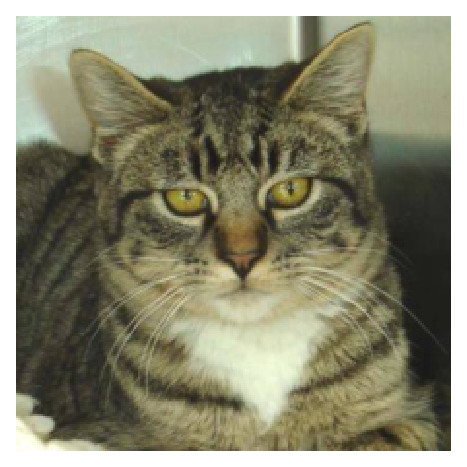

In [3]:
# Run this to test your data loader
images, labels = next(iter(dataloader))
helper.imshow(images[0], normalize=False)

If you loaded the data correctly, you should see something like this (your image will be different):

<img src='assets/cat_cropped.png' width=244>

## Data Augmentation

A common strategy for training neural networks is to introduce randomness in the input data itself. For example, you can randomly rotate, mirror, scale, and/or crop your images during training. This will help your network generalize as it's seeing the same images but in different locations, with different sizes, in different orientations, etc.

To randomly rotate, scale and crop, then flip your images you would define your transforms like this:

```python
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])
```

You'll also typically want to normalize images with `transforms.Normalize`. You pass in a list of means and list of standard deviations, then the color channels are normalized like so

```input[channel] = (input[channel] - mean[channel]) / std[channel]```

Subtracting `mean` centers the data around zero and dividing by `std` squishes the values to be between -1 and 1. Normalizing helps keep the network work weights near zero which in turn makes backpropagation more stable. Without normalization, networks will tend to fail to learn.

You can find a list of all [the available transforms here](http://pytorch.org/docs/0.3.0/torchvision/transforms.html). When you're testing however, you'll want to use images that aren't altered (except you'll need to normalize the same way). So, for validation/test images, you'll typically just resize and crop.

>**Exercise:** Define transforms for training data and testing data below.

In [4]:
data_dir = 'Cat_Dog_data'
test_error_case = False

# DONE: Define transforms for the training data and testing data
train_transforms = transforms.Compose([#transforms.Grayscale(num_output_channels=1),
                                       transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()])    

# The error case here involves setting up the training transforms as described above,
# which generates an error in the test dataset forward model propagation
if test_error_case == True:
    test_transforms = transforms.Compose([#transforms.Grayscale(num_output_channels=1),
                                          transforms.Resize(255),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor()])
    
# This case runs the test dataset through the same random transforms as the training dataset.
# This is expressly not recommended in the video and guidance for this part, but it is included
# here to illustrate the behavioral difference between these two cases
elif test_error_case == False:
    test_transforms = transforms.Compose([#transforms.Grayscale(num_output_channels=1),
                                       transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainsampler = torch.utils.data.sampler.SubsetRandomSampler(np.arange(64))

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, sampler=trainsampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

torch.Size([3, 224, 224])
<built-in method type of Tensor object at 0x7f6b51fe0870>
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
<built-in method type of Tensor object at 0x7f6b51fe08b8>
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
<built-in method type of Tensor object at 0x7f6b51fe0870>
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
<built-in method type of Tensor object at 0x7f6b51fe08b8>
torch.Size([3, 224, 224])


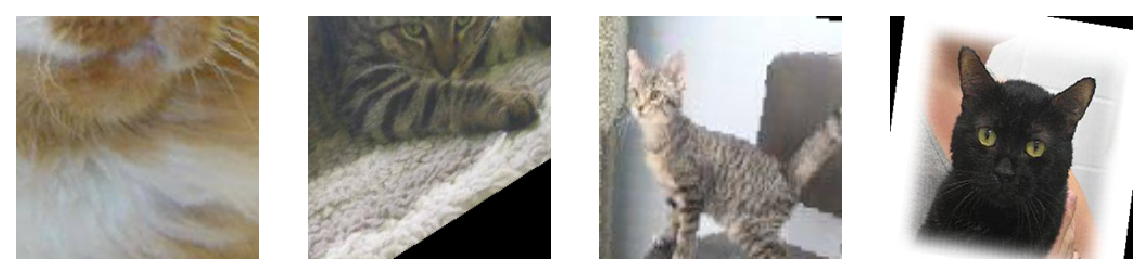

In [5]:
import numpy as np

# change this to the trainloader or testloader 
data_iter = iter(testloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    print(images[ii].shape)
    print(images[ii].type)
    ax = axes[ii]
    #disp_image = torch.cat((images[ii], images[ii], images[ii]))
    disp_image = images[ii]
    print(disp_image.shape)
    helper.imshow(disp_image, ax=ax, normalize=False)

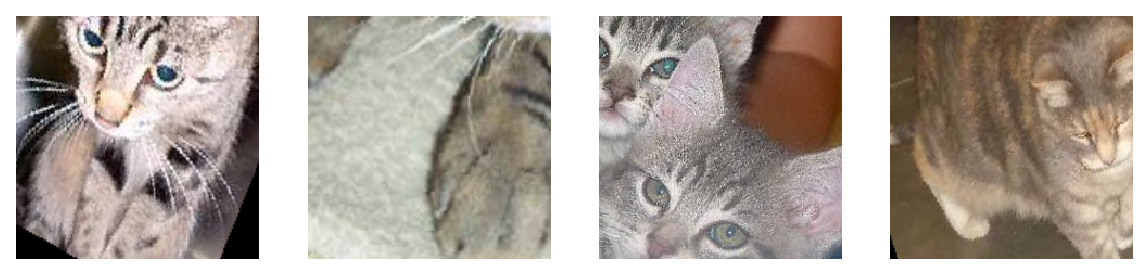

In [6]:
# change this to the trainloader or testloader 
data_iter = iter(trainloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    #disp_image = torch.cat((images[ii], images[ii], images[ii]))
    disp_image = images[ii]
    helper.imshow(disp_image, ax=ax, normalize=False)

Your transformed images should look something like this.

<center>Training examples:</center>
<img src='assets/train_examples.png' width=500px>

<center>Testing examples:</center>
<img src='assets/test_examples.png' width=500px>

At this point you should be able to load data for training and testing. Now, you should try building a network that can classify cats vs dogs. This is quite a bit more complicated than before with the MNIST and Fashion-MNIST datasets. To be honest, you probably won't get it to work with a fully-connected network, no matter how deep. These images have three color channels and at a higher resolution (so far you've seen 28x28 images which are tiny).

In the next part, I'll show you how to use a pre-trained network to build a model that can actually solve this problem.

In [7]:
# Optional DONE: Attempt to build a network to classify cats vs dogs from this dataset

In [8]:
from torch import nn

# Define the network architecture here
n_input = 224*224*3
n_hidden = [64*64, 32*32, 16*16, 4*4]
n_output = 2

model = nn.Sequential(
    nn.Linear(n_input, n_hidden[0]),
    nn.ReLU(),
    nn.Linear(n_hidden[0], n_hidden[1]),
    nn.ReLU(),
    nn.Linear(n_hidden[1], n_hidden[2]),
    nn.ReLU(),
    nn.Linear(n_hidden[2], n_hidden[3]),
    nn.ReLU(),
    nn.Linear(n_hidden[3], n_output),
    nn.LogSoftmax(dim=1))

print(model)

Sequential(
  (0): Linear(in_features=150528, out_features=4096, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4096, out_features=1024, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1024, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=16, bias=True)
  (7): ReLU()
  (8): Linear(in_features=16, out_features=2, bias=True)
  (9): LogSoftmax()
)


In [9]:
from torch import optim

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)

In [ ]:
# Train the network

epochs = 3
for e in range(epochs):
    running_loss = 0
    batch_counter = 0
    for images, labels in trainloader:
        # Flatten images into 1D vector
        print(images.type)
        print(images.shape)
        print(labels.type)
        print(labels.shape)
        batch_counter += 1
        images = images.view(images.shape[0], -1)
        #print(images.shape)
        
        prefix = "(epoch {}/{} batch {}/{}) ".format(
            e + 1, epochs, batch_counter, len(trainloader))
        
        print(prefix + "Zeroing gradients...")
        optimizer.zero_grad()
        print(prefix + "Running forward pass...")
        output = model.forward(images)
        print(prefix + "Evaluating loss...")
        loss = criterion(output, labels)
        print(prefix + "Backpropagating...")
        loss.backward()
        print(prefix + "Stepping optimizer...")
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("({}/{}) Training loss is {:.4f}".format(
            e + 1, epochs, running_loss/len(trainloader)))
        
        # Run against validation data set
        test_losses = []
        test_accuracies = []

        with torch.no_grad():
            test_loss = 0
            n_test_images = 0
            n_correct_images = 0
            batch_counter = 0
            for test_images, test_labels in testloader:
                print(test_images.type)
                print(test_images.shape)
                print(test_labels.type)
                print(test_labels.shape)
                batch_counter += 1
                # Get the log probabilities from a forward pass
                log_ps = model.forward(test_images)
                # Update the test loss
                test_loss += criterion(log_ps, test_labels)
                # Get the class probabilities
                ps = torch.exp(log_ps)
                # Get the top result
                top_p, top_class = ps.topk(1, dim=1)
                # Evaluate the top result for each image
                equals = (top_class == test_labels.view(*top_class.shape))

                n_correct_images += torch.sum(equals)
                n_test_images += len(test_labels)

                accuracy = torch.mean(equals.type(torch.FloatTensor))
                print("(batch {}/{}) accuracy = {:.3f}%".format(batch_counter, len(testloader), accuracy.item()*100.0))

            test_losses.append(test_loss/len(testloader))
            test_accuracies.append(100.0*n_correct_images.float()/float(n_test_images))

            print("({}/{}) Total Validation Loss = {:.4f}, Validation Accuracy = {:.3f}%".format(
                e + 1, epochs, test_losses[-1], test_accuracies[-1]))

<built-in method type of Tensor object at 0x7f6b51f5cf78>
torch.Size([32, 3, 224, 224])
<built-in method type of Tensor object at 0x7f6b51e36900>
torch.Size([32])
(epoch 1/3 batch 1/2) Zeroing gradients...
(epoch 1/3 batch 1/2) Running forward pass...
(epoch 1/3 batch 1/2) Evaluating loss...
(epoch 1/3 batch 1/2) Backpropagating...
(epoch 1/3 batch 1/2) Stepping optimizer...
<built-in method type of Tensor object at 0x7f6b51e40fc0>
torch.Size([32, 3, 224, 224])
<built-in method type of Tensor object at 0x7f6b51e401b0>
torch.Size([32])
(epoch 1/3 batch 2/2) Zeroing gradients...
(epoch 1/3 batch 2/2) Running forward pass...


Here is the error that was produced in the (test_error_case == True) setup. 

As it turns out, it also is produced in the (test_error_case == False) case.

In [ ]:
<built-in method type of Tensor object at 0x7fb179df9708>
torch.Size([32, 1, 224, 224])
<built-in method type of Tensor object at 0x7fb179df50d8>
torch.Size([32])
(epoch 1/3 batch 1/2) Zeroing gradients...
(epoch 1/3 batch 1/2) Running forward pass...
(epoch 1/3 batch 1/2) Evaluating loss...
(epoch 1/3 batch 1/2) Backpropagating...
(epoch 1/3 batch 1/2) Stepping optimizer...
<built-in method type of Tensor object at 0x7fb179df5510>
torch.Size([32, 1, 224, 224])
<built-in method type of Tensor object at 0x7fb179d9f048>
torch.Size([32])
(epoch 1/3 batch 2/2) Zeroing gradients...
(epoch 1/3 batch 2/2) Running forward pass...
(epoch 1/3 batch 2/2) Evaluating loss...
(epoch 1/3 batch 2/2) Backpropagating...
(epoch 1/3 batch 2/2) Stepping optimizer...
(1/3) Training loss is 0.4440
<built-in method type of Tensor object at 0x7fb179df90d8>
torch.Size([32, 1, 224, 224])
<built-in method type of Tensor object at 0x7fb179d9f090>
torch.Size([32])

---------------------------------------------------------------------------
RuntimeError                              Traceback (most recent call last)
<ipython-input-10-c754ebf82091> in <module>()
     50                 batch_counter += 1
     51                 # Get the log probabilities from a forward pass
---> 52                 log_ps = model.forward(images)
     53                 # Update the test loss
     54                 test_loss += criterion(log_ps, labels)

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/container.py in forward(self, input)
     89     def forward(self, input):
     90         for module in self._modules.values():
---> 91             input = module(input)
     92         return input
     93 

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/module.py in __call__(self, *input, **kwargs)
    489             result = self._slow_forward(*input, **kwargs)
    490         else:
--> 491             result = self.forward(*input, **kwargs)
    492         for hook in self._forward_hooks.values():
    493             hook_result = hook(self, input, result)

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/linear.py in forward(self, input)
     53 
     54     def forward(self, input):
---> 55         return F.linear(input, self.weight, self.bias)
     56 
     57     def extra_repr(self):

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py in linear(input, weight, bias)
    992         return torch.addmm(bias, input, weight.t())
    993 
--> 994     output = input.matmul(weight.t())
    995     if bias is not None:
    996         output += bias

RuntimeError: size mismatch, m1: [7168 x 224], m2: [50176 x 4096] at /opt/conda/conda-bld/pytorch_1524584710464/work/aten/src/TH/generic/THTensorMath.c:2033

In [ ]:
# Save the model
print(prefix + "Saving checkpoint...")

checkpoint = {
    'input_size': n_input,
    'output_size': n_output,
    'epoch': e,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss}

torch.save(checkpoint, 'checkpoint.pth')

In [ ]:
# This relies on fc_model.py
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = fc_model.Network(checkpoint['input_size'],
                             checkpoint['output_size'],
                             checkpoint['hidden_layers'])
    
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [ ]:
# Load the checkpoint
# Doesn't seem to work because of absence of fc_model.py

#model = load_checkpoint('checkpoint.pth')